## Input Parameters

In [1]:

#source EPOTFenv/bin/activate (launching and exiting the virtual environment containing the required modules, stored in the working directory)
#EPOTFenv/bin/python your_script.py - for running a script in the virtual environment
#source deactivate

# Import all the libraries needed
from import_dep import *
# Import custom plot style and colorbar functions
from Functions_style import set_plot_style, add_colorbar, generate_colormaps_and_normalizers, add_slide, sample_tag_gen
# Import the data import functions 
from Class_Import import PPMSData, import_ppms_data, import_all_datasets
# Import the general functions
from Functions_General import extract_ctf, magnetoresistance, update_plot_string, filter_data
# Import the functions for VDP processing
from Functions_VDP import vdp_resistivity, vdp_hall
# Import the functions used for HallBar processing
from Functions_HallBar import hallbar_resistivity, hallbar_hall

# import the fitting functions
from Functions_Fitting import poly_to_string


### Plotting and Output Variables 
export_data = True # set to True to export the data to a powerpoint presentation and as svg files and export to path_out
powerpoint_string = 'Mobility' # string to be added to the powerpoint file name
fig_format = 'svg' # format of the figure to be saved
plot_transparency = True # set to True to make the data plots transparent
error_shade = True # set to True to plot the error bars as shaded regions else they are plotted as lines
fig_list = [] # Create a list to flexibly store tuples with the (figure, filename, title) for later exporting
ohm_m = 0 #set to 1 to force ohm-m units 0 to keep micro ohm cm units



# Custom Scence style settings for figures
fig_size = set_plot_style(export_data = export_data, use_tex=True)
#plt.style.use(['science', 'grid', 'nature'])

# Import all the raw measured data for VDP and HallBar
dat_raw_vdp, dat_raw_hb = import_all_datasets()

File 1 imported: JT029_SrRuO3_silver_Combined with shape (650, 5, 6)
File 2 imported: JT029_SrRuO3_silver_Combined4 with shape (7920, 5, 6)
File 3 imported: JT029_SrRuO3_silver_Combined_fullrange.txt with shape (850, 5, 6)
File 4 imported: JT029_SrRuO3_silver_HallRun1 with shape (72, 5, 6)
File 5 imported: JT029_SrRuO3_silver_Halltest2 with shape (68, 5, 6)
File 1 imported: HC003_BaSnO3_STO_061124_Hall with shape (3024, 5, 6)
File 1 imported: YF042_HfO2_STO_nosilver_Hall_2 with shape (3660, 5, 6)
File 2 imported: YF042_HfO2_STO_silver_Hall_3 with shape (2970, 5, 6)
File 3 imported: YF042_HfO2_STO_silver_Hall_5 with shape (2508, 5, 6)
File 4 imported: YF042_HfO2_STO_silver_Hall_6 with shape (2442, 5, 6)
File 5 imported: YF042_HfO2_STO_silver_Hall_7 with shape (3080, 5, 6)
Could not read headers to check for rotator in file: YFW042_HZO_IV_resistivity.png, 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
Error with file: YFW042_HZO_IV_resistivity.png, 'utf-8' codec c

## Select Data for Plotting ***********************************************

In [2]:
# First visualise the data contained in each list
for count, dat in enumerate(dat_raw_vdp+dat_raw_hb):
    print(f'dat_{count}:', [f'{count_2}={d.filename}' for count_2, d in enumerate(dat)])

#dat_raw_sel = [dat_raw_vdp[13][5], dat_raw_vdp[13][2], dat_raw_vdp[13][3]] # DV127

#dat_raw_sel = [  dat_raw_vdp[14][7],dat_raw_vdp[19][3]] # DR low oxygen double layer comparison $O_2$ - 700°C, 2h
#dat_raw_sel = [ dat_raw_vdp[17][1], dat_raw_vdp[18][2],  dat_raw_vdp[14][7]] #,DR O2 growth comparison 0.13mbar $O_2$ $BaSnO_3$
#dat_raw_sel =  [dat_raw_vdp[14][5], dat_raw_vdp[14][1], dat_raw_vdp[14][7]] # DR008a $O_2$ - 700°C, 2h

#dat_raw_sel = [dat_raw_vdp[22][9]]#dat_raw_vdp[17][1], dat_raw_vdp[17][5],  dat_raw_vdp[17][0]] # Silver contamination - HC011 vs DR009 before/after

# Dennis DV127
dat_raw_sel = [dat_raw_hb[1][0], dat_raw_hb[0][1]] # DV127 hallbar

mag_dat = dat_raw_sel
print('dat_raw_sel:', [f'{count}={d.filename}' for count, d in enumerate(dat_raw_sel)])


dat_0: ['0=JT029_SrRuO3_silver_Combined', '1=JT029_SrRuO3_silver_Combined4', '2=JT029_SrRuO3_silver_Combined_fullrange.txt', '3=JT029_SrRuO3_silver_HallRun1', '4=JT029_SrRuO3_silver_Halltest2']
dat_1: ['0=HC003_BaSnO3_STO_061124_Hall']
dat_2: ['0=YF042_HfO2_STO_nosilver_Hall_2', '1=YF042_HfO2_STO_silver_Hall_3', '2=YF042_HfO2_STO_silver_Hall_5', '3=YF042_HfO2_STO_silver_Hall_6', '4=YF042_HfO2_STO_silver_Hall_7']
dat_3: ['0=DR001_LaScO3__BaSnO3_STO_201124_test1', '1=DR004_LaScO3__BaSnO3_STO_201124_combined3', '2=DR004_LaScO3__BaSnO3_STO_201124_combined4', '3=DR004_LaScO3__BaSnO3_STO_201124_combined5', '4=DR004_LaScO3__BaSnO3_STO_201124_combined6', '5=DR004_LaScO3__BaSnO3_STO_201124_test2']
dat_4: ['0=DR003_LaScO3__BaSnO3_STO_nosilver_combined1', '1=DR003_LaScO3__BaSnO3_STO_nosilver_combined2', '2=DR003_LaScO3__BaSnO3_STO_nosilver_test2', '3=DR003_LaScO3__BaSnO3_STO_nosilver_test3', '4=DR003_LaScO3__BaSnO3_STO_nosilver_test4', '5=DR003_LaScO3__BaSnO3_STO_silver_combined10', '6=DR003_LaSc

## ************************************************************************************************************************

## Extract and Check Temperature, Field, and Current values

In [3]:
# Reduced_data = [1,-5] means that the first and last 5 temperature points are removed from the data
# Reduced_temp = [3,-1] will skip the first 3 temperature points and the last 1 temperature point
# Reduced_current = 2 will skip the first 2 current points and the last 2 current points

# Extract Data - check you have the expected and correct Temperature, Field and Current values!
dat, unit_scale = extract_ctf(dat_raw_sel,Reduced_temp = False, Reduced_current=False, ohm_m=ohm_m, single_zero_field = True)


# Update a single data file with reduced temperature or current values
#dat[0] = extract_ctf([dat_raw_sel[0]], Reduced_temp = [1,0], Reduced_current=False, single_zero_field = True)[0][0]
#dat[3] = extract_ctf([dat_raw_sel[3]], Reduced_temp = [0,-2], Reduced_current=False, single_zero_field = True)[0][0]

# Generate the colormaps and normalizers for the data
[cmap_temp, cmap_field, norm_temp, norm_field, mark_p, min_temp, max_temp, min_field, max_field] = generate_colormaps_and_normalizers(dat)

# If exporting the data this ensures that the labels are updated by the user to be correct from their original "filename" assignement
if export_data == True: 
    dat = update_plot_string(dat)




tempshape 1
WARNING Potential Temperature Issues: The erronous temperature points are: [281.]
run13_DV127_WO3_YAO_HallBar4: Field values originally in the order 0,-Bmax->0->Bmax
For file: run13_DV127_WO3_YAO_HallBar4
9 Currents (uA): [-0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16]
13 Temperatures (K): [362. 342. 322. 302. 282. 262. 242. 222. 202. 182. 162. 142. 122.]
13 Fields (kOe): [-90. -75. -60. -45. -30. -15.  -0.  15.  30.  45.  60.  75.  90.]
Is this correct?
tempshape 1
WARNING Potential Temperature Issues: The erronous temperature points are: [281.]
run11_DV127_WO3_YAO_HallBar: Field values originally in the order 0,-Bmax->0->Bmax
For file: run11_DV127_WO3_YAO_HallBar
9 Currents (uA): [-0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16]
11 Temperatures (K): [362. 342. 322. 302. 282. 262. 242. 222. 202. 182. 162.]
13 Fields (kOe): [-90. -75. -60. -45. -30. -15.  -0.  15.  30.  45.  60.  75.  90.]
Is this correct?
New plot string for run13_DV127_WO3_YAO_HallBar4: para

## Calculate VDP Resistivity, Magnetoresistance, Hall Coefficient and Hall Mobility


In [4]:
# Extract the resistivity using the VDP method and write to the PPMSData objects in the list "dat" - skips all non VDP data
dat = vdp_resistivity(dat, print_val = False, resistivity_guess = 0)
# Calculate the Hall coefficient and mobility - skips all non VDP data
dat = vdp_hall(dat)

# Calculate the resistivity using the HallBar method and write to the PPMSData objects in the list "dat" - skips all non HallBar data
dat = hallbar_resistivity(dat, print_val = False, filt_kern=0)
# calculate the Hall coefficient and mobility - skips all non HallBar data
dat = hallbar_hall(dat, filt_kern=0)
        
# Calculate the magnetoresistance at each temperature and field strength: mag_res(temperature, field, index) where: index 0 = VDP config A, index 1 = VDP config B, index 2 = average of A and B
dat = magnetoresistance(dat) 

## Resitivity vs Temperature for B=0 ONLY

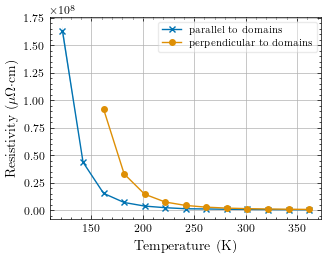

In [5]:
# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    # Use the middle B field index
    for Bi in [int(d.ctf[5]/2)]:
        x = d.res_data[:, Bi, 0]
        y = d.res_data[:, Bi, 4] * unit_scale
        y_err = d.res_data[:, Bi, 5] * unit_scale
        
        if error_shade:
            # Plot the main line
            line_main, = ax.plot(x, y, '-'+mark_p[j], label=f'{d.plot_str}')
            # Match fill color to line color
            color_main = line_main.get_color()
            # Fill the region for error
            ax.fill_between(x, y - y_err, y + y_err, color=color_main, alpha=0.3, edgecolor='none')
        else:
            # Standard error bars
            ax.errorbar(x, y, yerr=y_err, fmt='-'+mark_p[j], label=f'{d.plot_str}')

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'Sheet Resistance ($\Omega/\square$)')
elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
else:
    ax.set_ylabel(r'Resistivity ($\mu \Omega \cdot$cm)')

# Add a legend
ax.legend()

# Optional axis limits or scaling
#ax.set_yscale('log')
#ax.set_ylim(130,150)
# Show the plot
plt.show()

  
# Export Metadata 
plot_filename = f'{dat[0].sample_code}_{powerpoint_string}_rho_xx_H0_vs_temperature' # name for exported figure
plot_title = 'ρ_xy vs T at H=0' # title for powerpoint
notes = sample_tag_gen(dat) + [''] # notes for the powerpoint in text box starting with sample tag

# Append the figure, title and notes to the list for exporting later
fig_list.append((fig, plot_filename, plot_title, notes)) 

## Magnetoresistance vs H
- Plotting the magnetoresistance vs the Applied field strength (H) for several temperatures

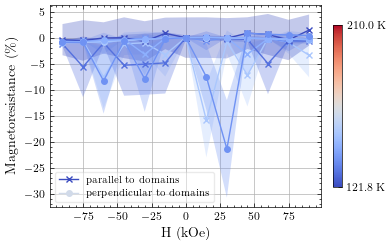

In [6]:

# Create a figure and GridSpec layout
fig = plt.figure(figsize=(fig_size[0] + fig_size[0]/9, fig_size[1]))
gs = gridspec.GridSpec(1, 2, width_ratios=[fig_size[0], fig_size[0]/9], wspace=0.0)

# Create the main plot
ax = fig.add_subplot(gs[0])

temp_limit = 210
# Normalize the temperature and field values
norm_temp_mag = Normalize(vmin=min_temp, vmax=temp_limit)

for j, d in enumerate(mag_dat):
    # Loop over the temperatures
    for Ti, T in enumerate(d.ctf[1]):
        if T < temp_limit:
            # X and Y data
            x = d.tf_av[Ti, :, 1] * 10            # Field in kOe
            y = d.mag_res[Ti, :, 2]              # MR average
            y_err = d.mag_res[Ti, :, 3]          # MR average error

            color_main = cmap_temp(norm_temp(T))

            if error_shade:
                # Plot main line
                ax.plot(x, y, marker=mark_p[j], color=color_main)
                # Fill the error region
                ax.fill_between(x, y - y_err, y + y_err, color=color_main, alpha=0.3, edgecolor='none')
            else:
                # Standard error bars
                ax.errorbar(x, y, yerr=y_err, marker=mark_p[j], color=color_main)

    # Add a dummy plot for the legend entry (same color as the last temperature used)
    ax.plot([], [], marker=mark_p[j], color=cmap_temp(norm_temp_mag(T)), label=f'{d.plot_str}')

ax.set_xlabel('H (kOe)')
ax.set_ylabel(r'Magnetoresistance (\%)')
#ax.set_title('Magnetoresistance vs Field')
ax.legend()

# Add and adjust the colorbar
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp_mag)
add_colorbar(fig, gs[1], sm, min_temp, temp_limit, fig_size, field=False)


#ax.set_ylim(-1,1)

plt.show()


# Export Metadata 
plot_filename = f'{dat[0].sample_code}_{powerpoint_string}_magnetoresistance_vs_field' # name for exported figure
plot_title = 'Magnetoresistance vs Field Strength' # title for powerpoint
notes = sample_tag_gen(dat) + [''] # notes for the powerpoint in text box starting with sample tag

# Append the figure, title and notes to the list for exporting later
fig_list.append((fig, plot_filename, plot_title, notes)) 

- The longitudinal resistance exhibits a rapid decrease, attributed to weak localization (WL), a phenomenon commonly observed in  disordered semiconductor systems
- The magnetoresistance (MR) exhibited a parabolic behavior within the intermediate magnetic field range (1.5T to 4T), as illustrated in Figure 5(b). Concurrently, at the fields where SdH oscillations emerge, it indicates the onset of quantum effects that dominate over the classical parabolic behavior.

## Arhenius Plot

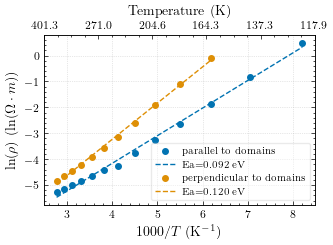

In [7]:
# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)  # Create a single subplot

# Define Boltzmann constant
k_B = 8.617333262e-5  # Boltzmann constant in eV/K

# Loop over the data sets
for j, d in enumerate(dat):
    # Extract data: 1000/T and ln(rho or Rs)
    # Assuming Bi_zero corresponds to the desired data column (e.g., zero field)
    Bi_zero = int(d.ctf[5] / 2)
    temp_K = d.res_data[:, Bi_zero, 0]
    rho_or_Rs = d.res_data[:, Bi_zero, 4]

    # Filter out invalid values simply (avoid division by zero or log(0))
    valid_mask = (temp_K > 0) & (rho_or_Rs > 0)
    temp_K = temp_K[valid_mask]
    rho_or_Rs = rho_or_Rs[valid_mask]

    x = 1000.0 / temp_K  # 1000/T
    y = np.log(rho_or_Rs)  # ln(rho) or ln(Rs)

    # Select the range of data for fitting (adjust the range as needed)
    # Ensure this range uses the 'x' variable (1000/T)
    fit_mask = (x > 0) & (x < 10)  # Fitting Range
    x_fit = x[fit_mask]
    y_fit = y[fit_mask]
    x = x[fit_mask]
    y = y[fit_mask]
    
    # Scatter plot of the data
    measurement_plot = ax.scatter(x, y, marker='o', label=f'{d.plot_str}')
    current_color = measurement_plot.get_facecolors()[0] # Get the color used for the scatter plot

    # Perform a linear fit only if enough points exist
    if len(x_fit) >= 2:
        coeffs = np.polyfit(x_fit, y_fit, 1)
        gradient = coeffs[0] # Slope of ln(rho) vs (1000/T)
        intercept = coeffs[1]

        # Calculate activation energy (Corrected: Ea = gradient * 1000 * k_B)
        activation_energy = gradient * 1000.0 * k_B # The key correction

        # Generate x values for the fitted line
        x_vals = np.linspace(x_fit.min(), x_fit.max(), 100)
        y_vals = np.polyval(coeffs, x_vals)

        # Plot the fitted line
        ax.plot(x_vals, y_vals, linestyle='--', color=current_color,
                label=f'Ea={activation_energy:.3f} eV') # Show Ea in label

# Set labels and title based on the first dataset's type
ax.set_xlabel(r'$1000/T$ (K$^{-1}$)')
if dat and dat[0].film_thickness == 1:
    ax.set_ylabel(r'$\ln(R_s)$  (ln($\Omega/\square$))')
else:
    ax.set_ylabel(r'$\ln(\rho)$  (ln($\Omega \cdot m$))')
#ax.set_title('Arrhenius Plot')

# Add a legend
ax.legend()
ax.grid(True, linestyle=':', alpha=0.6) # Optional grid

# Create a secondary x-axis for Temperature (K) at the top
ax2 = ax.twiny() # Share the y-axis
xlim = ax.get_xlim()
ax2.set_xlim(xlim)

# Calculate and set ticks for the Temperature axis
num_ticks = 6
ticks_1000_T = np.linspace(xlim[0], xlim[1], num=num_ticks)
valid_ticks_1000_T = ticks_1000_T[ticks_1000_T > 1e-9] # Avoid T = infinity
valid_ticks_T = 1000.0 / valid_ticks_1000_T

ax2.set_xticks(valid_ticks_1000_T)
ax2.set_xticklabels([f'{T_val:.1f}' for T_val in valid_ticks_T])
ax2.set_xlabel('Temperature (K)')
ax2.grid(False) # No grid for the top axis

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Export Metadata 
plot_filename = f'{dat[0].sample_code}_{powerpoint_string}_Arrhenius Plot' # name for exported figure
plot_title = 'Arrhenius Plot' # title for powerpoint
notes = sample_tag_gen(dat) + [''] # notes for the powerpoint in text box starting with sample tag

# Append the figure, title and notes to the list for exporting later
fig_list.append((fig, plot_filename, plot_title, notes)) 

## Log(R) vs Log(T)

- $5.08T$ + 10.47
- $5.79T$ + 12.56


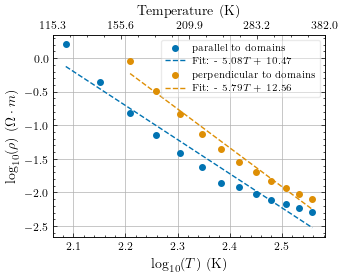

In [8]:
# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    # Plot log10(rho_film) vs log10(Temp)
    Bi_zero = int(d.ctf[5]/2)
    log_T = np.log10(d.res_data[:, Bi_zero, 0])
    log_R = np.log10(d.res_data[:, Bi_zero, 4])
    measurement_plot = ax.scatter(log_T, log_R, marker='o', linestyle='-', label=f'{d.plot_str}')
    current_color = measurement_plot.get_facecolors()[0] # Get the color used for the scatter plot

    # Fit to a polynomial of order...
    poly_order = 1
    coeffs = np.polyfit(log_T, log_R, poly_order)
    
    # Convert to readable equation string
    equation = poly_to_string(coeffs)
    print(str(equation))
    
    # Generate x values for the fitted line
    x_vals = np.linspace(np.min(log_T), np.max(log_T), 100)

    # Plot with equation in label
    ax.plot(x_vals, np.polyval(coeffs, x_vals), 
            label=f'Fit: {str(equation)}', 
            linestyle='--', color=current_color )



# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel(r'$\log_{10}(T)$ (K)')

if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$\log_{10}(R_s)$ ($\Omega/ \square$)')
    #ax.set_title(r'Log-Log Plot of Sheet Resistance vs Temperature')
else:
    ax.set_ylabel(r'$\log_{10}(\rho)$ ($\Omega \cdot m$)')
    #ax.set_title(r'Log-Log Plot of Resistivity vs Temperature')


# Add lines of n=1 and n=2 with best fit intercepts
x_vals = np.linspace(np.log10(min_temp), np.log10(max_temp), 100)


    
# Add a legend
ax.legend()

# Create a secondary x-axis at the top
ax2 = ax.twiny()

#ax.set_xlim(1.2, 2.5)

# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())

# Set the ticks and labels for the secondary x-axis
log_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=5)
ax2.set_xticks(log_ticks)
ax2.set_xticklabels([f'{10**tick:.1f}' for tick in log_ticks])
ax2.set_xlabel('Temperature (K)')

# Disable grid lines for the secondary x-axis
ax2.grid(False)

# Show the plot
plt.show()


# Export Metadata 
plot_filename = f'{dat[0].sample_code}_{powerpoint_string}_LogR_vs_LogT' # name for exported figure
plot_title = 'Log(resitivity) vs Log(temperature)' # title for powerpoint
notes = sample_tag_gen(dat) + [''] # notes for the powerpoint in text box starting with sample tag

# Append the figure, title and notes to the list for exporting later
fig_list.append((fig, plot_filename, plot_title, notes)) 

## Hall Resistivity vs Field

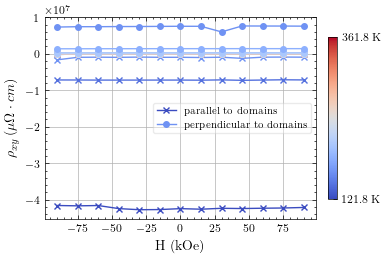

In [9]:
# Create a figure and GridSpec layout
fig = plt.figure(figsize= (fig_size[0] + fig_size[0]/9 , fig_size[1]) )
gs = gridspec.GridSpec(1, 2, width_ratios=[fig_size[0], fig_size[0]/9], wspace=0.0)

# Create the main plot
ax = fig.add_subplot(gs[0])

# Add and adjust the colorbar using a custom function
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
add_colorbar(fig, gs[1], sm, min_temp, max_temp, fig_size, field = False)


# Loop over the data sets
for j, d in enumerate(dat):

    for Ti, T in enumerate(d.ctf[1], start=0):

        # Plot rho_film vs Temp
        ax.plot(d.hall_data[Ti, :, 1]*10, d.hall_data[Ti, :, 6]*unit_scale, marker=mark_p[j], color=cmap_temp(norm_temp(T)))
        
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_temp(norm_temp(T)), label=f'{d.plot_str}')


# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('H (kOe)')
if dat[0].film_thickness == 1:

    ax.set_ylabel(r'$R_{s}\{xy\}$ ($\Omega/\square$)')
    #ax.set_title(r'$R_{s}\{xy\}$' f' of {d.material} vs Applied Field')
    
elif ohm_m == 1:
    ax.set_ylabel(r'$\rho_{xy}\, ($\Omega \cdot$m)')
    #ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field')
    
else:
    ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
    #ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field')
    


# Add a legend
ax.legend()

#ax.set_ylim(-500,50)
# Show the plot
plt.show()

# Export Metadata 
plot_filename = f'{dat[0].sample_code}_{powerpoint_string}_rho_xy_vs_field' # name for exported figure
plot_title = 'ρ_xy vs H' # title for powerpoint
notes = sample_tag_gen(dat) + [''] # notes for the powerpoint in text box starting with sample tag

# Append the figure, title and notes to the list for exporting later
fig_list.append((fig, plot_filename, plot_title, notes)) 


## Charge Carrier Density Only

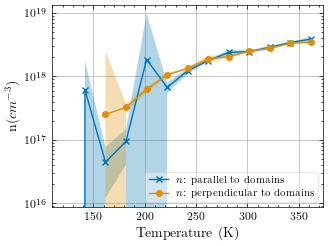

In [10]:
# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)  # Create a single subplot

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$n\cdot t$' r'($cm^{-2}$)')
    n_label = r'$n\cdot t$: '
else:
    ax.set_ylabel(r'n($cm^{-3}$)')
    n_label = r'$n$: '

for j, d in enumerate(dat):
    x = d.hall_coefficient[:, 0]
    y = d.hall_coefficient[:, 7]
    y_err = d.hall_coefficient[:, 8]
    
    if error_shade:
        # Plot the main line first
        line_main, = ax.plot(x, y, '-'+mark_p[j], label=f'{n_label}{d.plot_str}')
        
        # Extract the line color to use for fill
        color_main = line_main.get_color()
        
        # Fill the error region
        ax.fill_between(x, y - y_err, y + y_err, color=color_main, alpha=0.3, edgecolor='none')
    else:
        # Standard error bars
        ax.errorbar(x, y, yerr=y_err, fmt='-'+mark_p[j], label=f'{n_label}{d.plot_str}')

# Add a legend for the y-axis
ax.legend()

ax.set_yscale('log')
#ax.set_ylim(1e1, 1e14)

# Show the plot
plt.show()

    
# Export Metadata 
plot_filename = f'{dat[0].sample_code}_{powerpoint_string}_n_only_vs_temperature' # name for exported figure
plot_title = 'Charge Carrier Density vs Temperature' # title for powerpoint
notes = sample_tag_gen(dat) + [''] # notes for the powerpoint in text box starting with sample tag

# Append the figure, title and notes to the list for exporting later
fig_list.append((fig, plot_filename, plot_title, notes)) 

## Mobility Fitting
## Mobility vs. Temperature Dependence ($μ \propto T^n$) Summary

Here's a breakdown of common temperature dependencies for electron mobility ($\mu$) arising from different dominant scattering mechanisms. The exponent $n$ is determined by how the average momentum relaxation time $\langle \tau \rangle$ varies with temperature ($T$), using the general relation $\mu = q\langle \tau \rangle / m^*$.

---

*   **$n = +3/2$: Ionized Impurity Scattering**
    *   **Dominance:** Low temperatures in doped, non-degenerate semiconductors.
    *   **Formula Origin:**
        The relaxation time scales with average electron energy ($E$) and ionized impurity density ($N_I$) as:
        ```math
        \langle \tau_{ii} \rangle \propto \frac{E^{3/2}}{N_I}
        ```
        Since $E \approx \frac{3}{2}kT$, where $k$ is Boltzmann's constant, we have $\langle \tau_{ii} \rangle \propto (kT)^{3/2}$. Assuming $N_I$ is constant.
    *   **Result:** $\mu_{ii} \propto \langle \tau_{ii} \rangle \propto T^{3/2}$
    *   **Physical Reason:** Scattering occurs via Coulomb interaction with fixed charged impurities. Faster electrons (higher $T$, higher $E$) interact for a shorter time with the impurity's potential, leading to less deflection (scattering cross-section $\sigma_{ii} \propto E^{-2} \propto T^{-2}$) and a longer relaxation time.

---

*   **$n = -3/2$: Acoustic Phonon Scattering (Deformation Potential)**
    *   **Dominance:** Higher temperatures in relatively pure, non-degenerate bulk semiconductors.
    *   **Formula Origin:**
        The scattering rate ($1/\langle \tau_{ac} \rangle$) depends on the effective mass ($m^*$), electron energy ($E$), phonon population ($N_{ph}$), and the interaction matrix element:
        ```math
        \frac{1}{\langle \tau_{ac} \rangle} \propto (m^*)^{3/2} E^{1/2} N_{ph}(E) |\text{Matrix Element}|^2
        ```
        For acoustic phonons via deformation potential, $N_{ph}$ contributing to scattering is roughly proportional to $kT$ (for $kT \gg \hbar\omega$) and $E \propto kT$. The matrix element is approximately constant.
        ```math
        \frac{1}{\langle \tau_{ac} \rangle} \propto (kT)^{1/2} (kT) \implies \frac{1}{\langle \tau_{ac} \rangle} \propto T^{3/2} \implies \langle \tau_{ac} \rangle \propto T^{-3/2}
        ```
    *   **Result:** $\mu_{ac} \propto \langle \tau_{ac} \rangle \propto T^{-3/2}$
    *   **Physical Reason:** Electrons scatter off lattice vibrations (phonons). Higher temperatures increase the number and amplitude of vibrations ($N_{ph} \propto T$), making collisions more frequent and reducing the relaxation time.

---

*   **$n = 0$: Temperature-Independent Scattering**
    *   **Dominance:** Varies. Can limit low-T mobility if impurity scattering is weak/screened. Important in 2DEGs.
    *   **Mechanisms & Origin:**
        *   **Neutral Impurity Scattering:** The scattering cross-section ($\sigma_{ni}$) is largely independent of electron energy $E$. Relaxation time $\langle \tau_{ni} \rangle \propto 1 / (N_n v_{th} \sigma_{ni})$. Since thermal velocity $v_{th} \propto E^{1/2} \propto T^{1/2}$ and $\sigma_{ni} \approx \text{const}$, $\langle \tau_{ni} \rangle$ might have a weak $T^{-1/2}$ dependence *if* this were strictly dominant, but often considered $\sim T^0$ in simplified pictures or when other mechanisms interfere.
        *   **Interface Roughness Scattering (2DEG):** Scattering depends on interface quality ($\Delta$ = height fluctuation, $\Lambda$ = correlation length) and electron confinement (wavefunction extent). In basic models, the relaxation time $\langle \tau_{ir} \rangle$ is primarily dependent on these structural factors and carrier density (via screening), not strongly on $T$.
        *   **Alloy Scattering:** Random potential fluctuations in alloys; scattering rate is weakly dependent on $T$.
    *   **Result:** $\mu \approx \text{Constant}$ (or weakly dependent on $T$)
    *   **Physical Reason:** The fundamental scattering mechanism (e.g., short-range potential of a neutral atom, physical bumps at an interface) doesn't change its effectiveness significantly with the average carrier thermal energy ($kT$).

---

*   **$n = -1/2$: Piezoelectric Scattering**
    *   **Dominance:** Low to intermediate temperatures in non-centrosymmetric crystals (e.g., III-V compounds like GaAs).
    *   **Formula Origin:**
        The scattering rate depends on temperature and energy:
        ```math
        \frac{1}{\langle \tau_{pz} \rangle} \propto \frac{T}{E^{1/2}} \quad (\text{simplified form from matrix elements and phonon population})
        ```
        Since $E \propto T$, we get:
        ```math
        \frac{1}{\langle \tau_{pz} \rangle} \propto \frac{T}{T^{1/2}} \propto T^{1/2} \implies \langle \tau_{pz} \rangle \propto T^{-1/2}
        ```
    *   **Result:** $\mu_{pz} \propto \langle \tau_{pz} \rangle \propto T^{-1/2}$
    *   **Physical Reason:** Acoustic phonons induce electric fields via the piezoelectric effect in certain crystals. Electrons scatter off these induced fields. The temperature dependence arises from the combination of phonon population ($\sim T$) and how the scattering effectiveness scales with electron energy ($\sim E^{-1/2}$).

---

*   **$n = -1$: Specific Cases (e.g., 2DEGs, Degenerate Systems, Dislocations)**
    *   **Dominance:** Can appear in various specific scenarios, often as a modification of acoustic phonon scattering.
    *   **Formula Origin:**
        *   **Acoustic Phonons in 2DEG/Degenerate Gas:** Screening effects and altered phase space (due to dimensionality or Fermi-Dirac statistics) change the calculation compared to the 3D non-degenerate case. Theories often yield $1/\langle \tau \rangle \propto T$, leading to $\mu \propto T^{-1}$.
        *   **Dislocation Scattering (Strain Field):** Some models considering scattering off the long-range strain field potential also yield $1/\langle \tau \rangle \propto T$, thus $\mu \propto T^{-1}$.
    *   **Result:** $\mu \propto T^{-1}$
    *   **Physical Reason:** Reflects changes in scattering dynamics due to reduced dimensionality, electron degeneracy (filled states limiting scattering final states), or the specific long-range nature of dislocation strain fields compared to simple point defects or bulk phonons.

---

*   **$n < -3/2$ (Steeper than $T^{-3/2}$, often exponential-like at onset): Optical Phonon Scattering**
    *   **Dominance:** High temperatures, particularly in polar materials (where electrons couple strongly to optical phonons via the Fröhlich interaction).
    *   **Formula Origin:**
        The scattering rate involves the optical phonon energy ($\hbar\omega_{opt}$) and population ($N_{ph}(\omega_{opt})$):
        ```math
        \frac{1}{\langle \tau_{op} \rangle} \propto [ N_{ph}(\omega_{opt}) \times (\text{absorption term}) + (N_{ph}(\omega_{opt})+1) \times (\text{emission term}) ] \times |\text{Matrix Element}|^2
        ```
        The key term is the optical phonon population (Bose-Einstein factor):
        ```math
        N_{ph}(\omega_{opt}) = \frac{1}{\exp(\hbar\omega_{opt} / kT) - 1}
        ```
        This factor grows very rapidly (exponentially-like onset) once $kT$ becomes comparable to $\hbar\omega_{opt}$.
    *   **Result:** Mobility drops sharply, $\mu_{op}$ decreases faster than any simple power law, often approximated locally or showing activated behavior ($\sim \exp(\hbar\omega_{opt} / kT)$ in the denominator of scattering rate/numerator of mobility).
    *   **Physical Reason:** Optical phonons have a relatively high, fixed energy $\hbar\omega_{opt}$. They are not significantly populated until $kT$ is comparable. Once thermally excited, they provide a very effective (often inelastic, involving large energy change) scattering channel, causing a rapid drop in mobility.

---

**Note:** These represent idealized limits. Real experimental data often shows transitions between regimes, and the fitted exponent $n$ in $\mu \propto T^n$ over a finite temperature range reflects the *net effect* of all simultaneously active scattering mechanisms, combined via approximations like Mathiessen's Rule ($1/\mu_{total} \approx \sum_i 1/\mu_i$).

- $0.84T$ + 0.96
- $2.40T$ + 1.46


/var/folders/xr/wc8tnsks36n8ywxxvqplwqch0000gn/T/ipykernel_8289/1430977742.py:43: RuntimeWarning: invalid value encountered in log10
  ax.fill_between(log_T, np.log10(y_mask - y_err_mask),


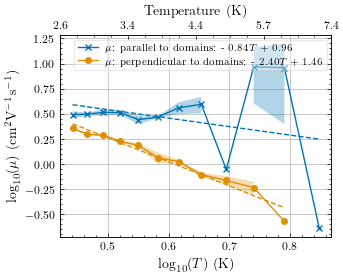

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)  # Create a single subplot

min_temp = 220
max_temp = 500
# Loop over the data sets
for j, d in enumerate(dat, start=0):
    if j < 4:
        # Extract temperature (T) and mobility (µ)
        x = 1000/d.hall_coefficient[:, 0]   # T
        y = d.hall_coefficient[:, 9]   # µ
        y_err = d.hall_coefficient[:, 10]

        # Filter out non-positive values to avoid log10(0) and filter certain temperature ranges
        mask = (x > min_temp) & (x < max_temp) &(y > 0)
        x_mask = x[mask]
        y_mask = y[mask]
        y_err_mask = y_err[mask]
        
        # Take log10 of T and µ
        log_T = np.log10(x_mask)
        log_u = np.log10(y_mask)
        

        # Perform a linear fit (poly_order = 1)
        poly_order = 1
        coeffs = np.polyfit(log_T, log_u, poly_order)
        eq_str = poly_to_string(coeffs)
        print(eq_str)  # Display the polynomial in the console

        # Generate x values for the fitted line
        x_vals = np.linspace(log_T.min(), log_T.max(), 100)
        y_vals = np.polyval(coeffs, x_vals)
        
        
        # Plot data
        ax.errorbar(log_T, log_u, yerr=None if not error_shade else None, 
                    fmt='-'+mark_p[j], label=rf'$\mu$: {d.plot_str}: {eq_str}')
        
        if error_shade:
            # Shade error region in log scale (optional)
            color_main = ax.lines[-1].get_color()
            ax.fill_between(log_T, np.log10(y_mask - y_err_mask), 
                                    np.log10(y_mask + y_err_mask), 
                            color=color_main, alpha=0.3, edgecolor='none')
        
        # Plot the fitted line
        ax.plot(x_vals, y_vals, linestyle='--', color=ax.lines[-1].get_color())

# Set log-log axis labels
ax.set_xlabel(r'$\log_{10}(T)$ (K)')
ax.set_ylabel(r'$\log_{10}(\mu)$ (cm$^2$V$^{-1}$s$^{-1}$)')

# Add a legend
ax.legend()

# Create a secondary x-axis at the top for normal T scale
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
log_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=5)
ax2.set_xticks(log_ticks)
ax2.set_xticklabels([f'{10**tick:.1f}' for tick in log_ticks])
ax2.set_xlabel('Temperature (K)')
ax2.grid(False)

plt.show()

# Export Metadata 
plot_filename = f'{dat[0].sample_code}_{powerpoint_string}_u_fit' # name for exported figure
plot_title = 'Log(u) vs Log(T) Fitted' # title for powerpoint
notes = sample_tag_gen(dat) + [''] # notes for the powerpoint in text box starting with sample tag

# Append the figure, title and notes to the list for exporting later
fig_list.append((fig, plot_filename, plot_title, notes)) 

## Exporting

#### Exporting All Figures as Individual Files

In [12]:
if export_data:
    for fig_obj, fig_filename, fig_title, notes in fig_list:
        save_path = Path(dat[0].directory) / Path(f"{dat[0].sample_code}_{powerpoint_string}_{fig_filename}.{fig_format}")
        fig_obj.savefig(save_path, dpi=600, bbox_inches='tight', transparent=plot_transparency)

#### Exporting to Powerpoint

In [13]:
if export_data == True:
    # Create a PowerPoint presentation object
    prs = Presentation()
    # Set slide dimensions to 16:9 widescreen (13.333 x 7.5 inches)
    [prs.slide_width, prs.slide_height] = [Inches(13.333), Inches(7.5)]

    # define the path to the output directory
    path_out = dat[0].directory

    # Add each figure to the PowerPoint presentation if it exists
    for fig, fig_filename, title, notes in fig_list:
        add_slide(fig, title, notes, prs, path_out = path_out, layout='Horizontal')

    # Save the PowerPoint presentation
    prs.save(Path(path_out) / Path(f'Fitting_{dat[0].sample_code}_{powerpoint_string}.pptx'))

Added slide: ρ_xy vs T at H=0 (Layout: Horizontal)
Added slide: Magnetoresistance vs Field Strength (Layout: Horizontal)
Added slide: Arrhenius Plot (Layout: Horizontal)
Added slide: Log(resitivity) vs Log(temperature) (Layout: Horizontal)
Added slide: ρ_xy vs H (Layout: Horizontal)
Added slide: Charge Carrier Density vs Temperature (Layout: Horizontal)
Added slide: Log(u) vs Log(T) Fitted (Layout: Horizontal)
